In [63]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [5]:
host = 'localhost'       
user = 'root'             
password = ''  
database = 'classicmodels'  

# Create the engine
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')


In [6]:
df_customers = pd.read_sql_query("SELECT * FROM customers", engine)
df_orders = pd.read_sql_query("SELECT * FROM orders", engine)
df_orderdetails = pd.read_sql_query("SELECT * FROM orderdetails", engine)
df_products = pd.read_sql_query("SELECT * FROM products", engine)
df_employees = pd.read_sql_query("SELECT * FROM employees", engine)
df_payments = pd.read_sql_query("SELECT * FROM payments", engine)


In [7]:
#Check for the number of null values in each column in the database, to decide what to do with them afterwards
print(df_customers.isnull().sum())
print(df_orders.isnull().sum())
print(df_orderdetails.isnull().sum())
print(df_products.isnull().sum())
print(df_employees.isnull().sum())

customerNumber              0
customerName                0
contactLastName             0
contactFirstName            0
phone                       0
addressLine1                0
addressLine2              100
city                        0
state                      73
postalCode                  7
country                     0
salesRepEmployeeNumber     22
creditLimit                 0
dtype: int64
orderNumber         0
orderDate           0
requiredDate        0
shippedDate        14
status              0
comments          246
customerNumber      0
dtype: int64
orderNumber        0
productCode        0
quantityOrdered    0
priceEach          0
orderLineNumber    0
dtype: int64
productCode           0
productName           0
productLine           0
productScale          0
productVendor         0
productDescription    0
quantityInStock       0
buyPrice              0
MSRP                  0
dtype: int64
employeeNumber    0
lastName          0
firstName         0
extension         0
ema

In [8]:
#Dealing with null values
#Customer
# Missing sales reps assigned a zero
df_customers['salesRepEmployeeNumber'] = df_customers['salesRepEmployeeNumber'].fillna(0)

# Drop the addressLine2 column(too many null values that don't contribute to the data analysis)
df_customers = df_customers.drop(columns=['addressLine2'])

# Fill missing values in state column with Unknown
df_customers['state'] = df_customers['state'].fillna('Unknown')

# Drop rows where postalCode is missing
df_customers = df_customers.dropna(subset=['postalCode'])



In [9]:
#Orders
#Fill null values to no comment
df_orders['comments'] = df_orders['comments'].fillna('No comment')


In [10]:
#Conversion of column names to lowercase and dates to datetime

df_customers.columns = df_customers.columns.str.lower()
df_orders.columns = df_orders.columns.str.lower()
df_orderdetails.columns = df_orderdetails.columns.str.lower()
df_products.columns = df_products.columns.str.lower()
df_employees.columns = df_employees.columns.str.lower()
df_payments.columns = df_payments.columns.str.lower()

df_orders['orderdate'] = pd.to_datetime(df_orders['orderdate'])
df_payments['paymentdate'] = pd.to_datetime(df_payments['paymentdate'])

print("Column names after conversion to lowercase:")
print("df_customers:", df_customers.columns)
print("df_orders:", df_orders.columns)
print("df_orderdetails:", df_orderdetails.columns)
print("df_products:", df_products.columns)
print("df_employees:", df_employees.columns)
print("df_payments:", df_payments.columns)



Column names after conversion to lowercase:
df_customers: Index(['customernumber', 'customername', 'contactlastname', 'contactfirstname',
       'phone', 'addressline1', 'city', 'state', 'postalcode', 'country',
       'salesrepemployeenumber', 'creditlimit'],
      dtype='object')
df_orders: Index(['ordernumber', 'orderdate', 'requireddate', 'shippeddate', 'status',
       'comments', 'customernumber'],
      dtype='object')
df_orderdetails: Index(['ordernumber', 'productcode', 'quantityordered', 'priceeach',
       'orderlinenumber'],
      dtype='object')
df_products: Index(['productcode', 'productname', 'productline', 'productscale',
       'productvendor', 'productdescription', 'quantityinstock', 'buyprice',
       'msrp'],
      dtype='object')
df_employees: Index(['employeenumber', 'lastname', 'firstname', 'extension', 'email',
       'officecode', 'reportsto', 'jobtitle'],
      dtype='object')
df_payments: Index(['customernumber', 'checknumber', 'paymentdate', 'amount'], dtype

In [11]:
#Merging the data in the various tables to form one big dataset
# Merge customers with orders
customers_orders = pd.merge(df_customers, df_orders, how='inner', on='customernumber')

# Merge the result with orderdetails
customers_orders_details = pd.merge(customers_orders, df_orderdetails, how='inner', on='ordernumber')

# Merge the result with products
consolidated_data = pd.merge(customers_orders_details, df_products, how='inner', on='productcode')

#Consolidated data
print(consolidated_data.head())


   customernumber       customername contactlastname contactfirstname  \
0             103  Atelier graphique         Schmitt          Carine    
1             103  Atelier graphique         Schmitt          Carine    
2             103  Atelier graphique         Schmitt          Carine    
3             103  Atelier graphique         Schmitt          Carine    
4             103  Atelier graphique         Schmitt          Carine    

        phone    addressline1    city    state postalcode country  ...  \
0  40.32.2555  54, rue Royale  Nantes  Unknown      44000  France  ...   
1  40.32.2555  54, rue Royale  Nantes  Unknown      44000  France  ...   
2  40.32.2555  54, rue Royale  Nantes  Unknown      44000  France  ...   
3  40.32.2555  54, rue Royale  Nantes  Unknown      44000  France  ...   
4  40.32.2555  54, rue Royale  Nantes  Unknown      44000  France  ...   

   priceeach  orderlinenumber                     productname   productline  \
0     120.71                2        

Descriptive Statistics:
       orderrevenue  quantityordered
count       2823.00          2823.00
mean        3208.11            35.16
std         1631.45             9.75
min          481.50             6.00
25%         1991.66            27.00
50%         2880.80            35.00
75%         4099.92            43.00
max        11503.14            97.00


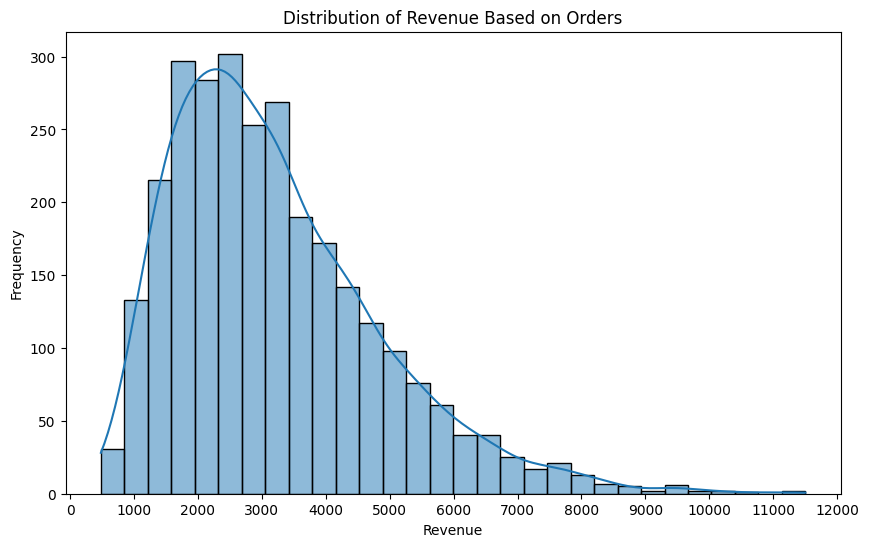

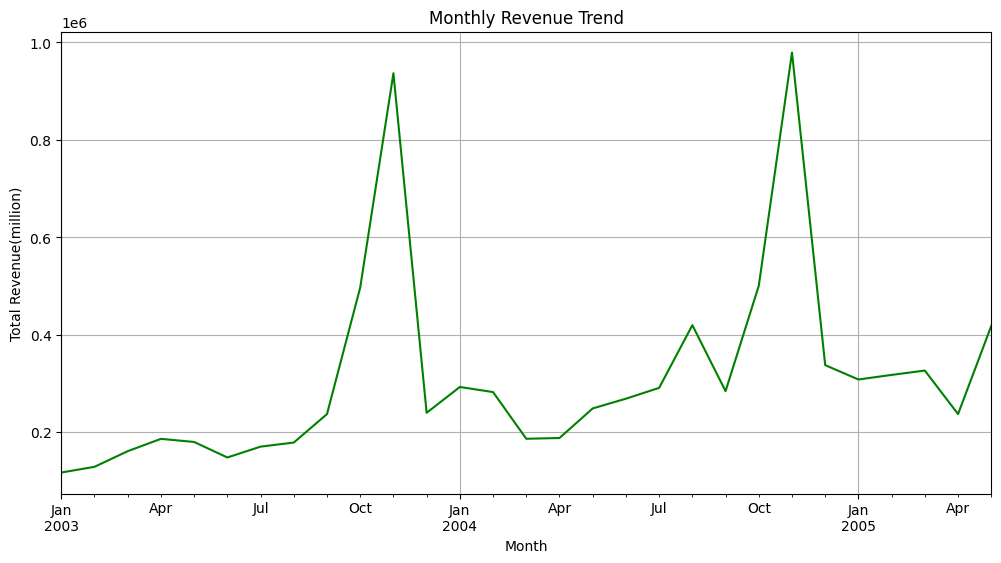

In [12]:
# Descriptive statistics for revenue and order sizes
print("Descriptive Statistics:")
consolidated_data['orderrevenue'] = consolidated_data['quantityordered'] * consolidated_data['priceeach']
stats = consolidated_data[['orderrevenue', 'quantityordered']].describe().round(2)
print(stats)

#Revenue distribution
plt.figure(figsize=(10, 6))
sns.histplot(consolidated_data['orderrevenue'], bins=30, kde=True)
plt.title("Distribution of Revenue Based on Orders")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
max_value = consolidated_data['orderrevenue'].max()
plt.xticks(range(0, int(max_value) + 1000, 1000))
plt.show()

#Monthly Sales Trend

monthly_revenue = (
    consolidated_data.groupby(consolidated_data['orderdate'].dt.to_period('M'))['orderrevenue']
    .sum()
)

monthly_revenue = monthly_revenue.astype(int)  # Or monthly_revenue.astype(int)

plt.figure(figsize=(12, 6))
monthly_revenue.plot(kind='line', title='Monthly Revenue Trend', color='green')
plt.xlabel('Month')
plt.ylabel('Total Revenue(million)')
plt.grid(True)
plt.show()





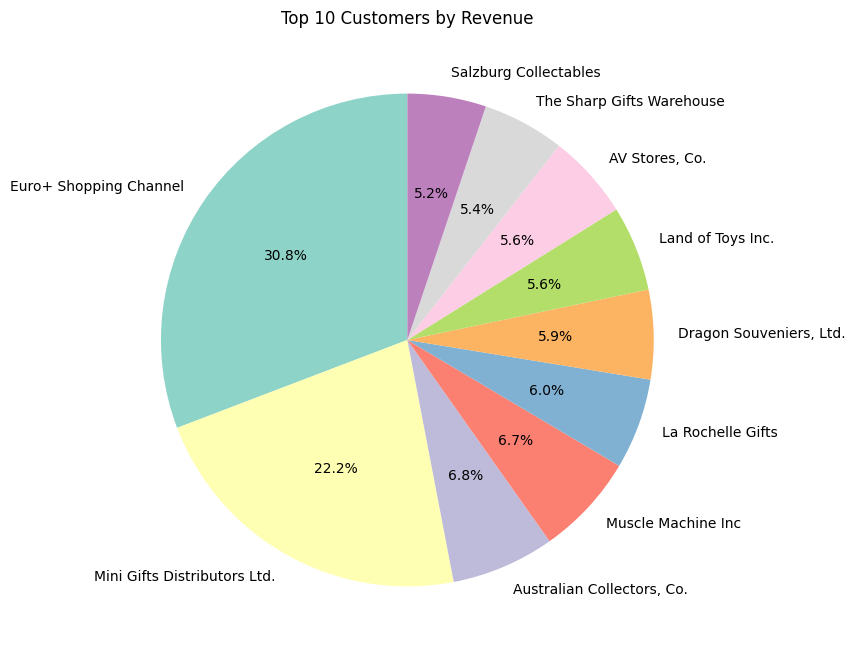

In [13]:
#Top 10 customers by revenue
consolidated_data['orderrevenue'] = consolidated_data['quantityordered'] * consolidated_data['priceeach']
customer_revenue = consolidated_data.groupby('customername')['orderrevenue'].sum()
customer_revenue = customer_revenue.sort_values(ascending=False)
top_customers = customer_revenue.head(10)

plt.figure(figsize=(8, 8))
top_customers.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3", len(top_customers)))
plt.title('Top 10 Customers by Revenue')
plt.ylabel('')
plt.show()

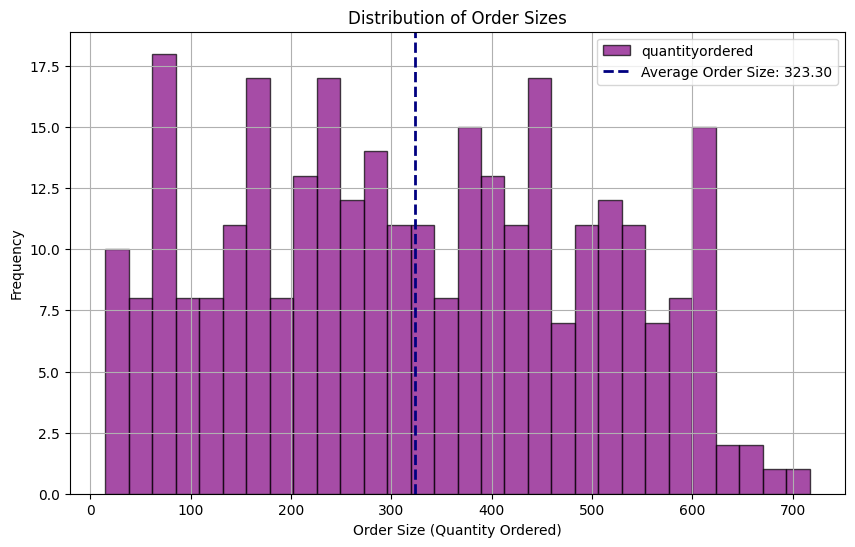

In [14]:
#2 Average Order Size
order_size = consolidated_data.groupby('ordernumber')['quantityordered'].sum()
average_order_size = order_size.mean()
plt.figure(figsize=(10, 6))
order_size.plot(kind='hist', bins=30, color='purple', edgecolor='black', alpha=0.7)
plt.title('Distribution of Order Sizes')
plt.xlabel('Order Size (Quantity Ordered)')
plt.ylabel('Frequency')
plt.axvline(average_order_size, color='navy', linestyle='dashed', linewidth=2, label=f'Average Order Size: {average_order_size:.2f}')
plt.legend()
plt.grid(True)
plt.show()

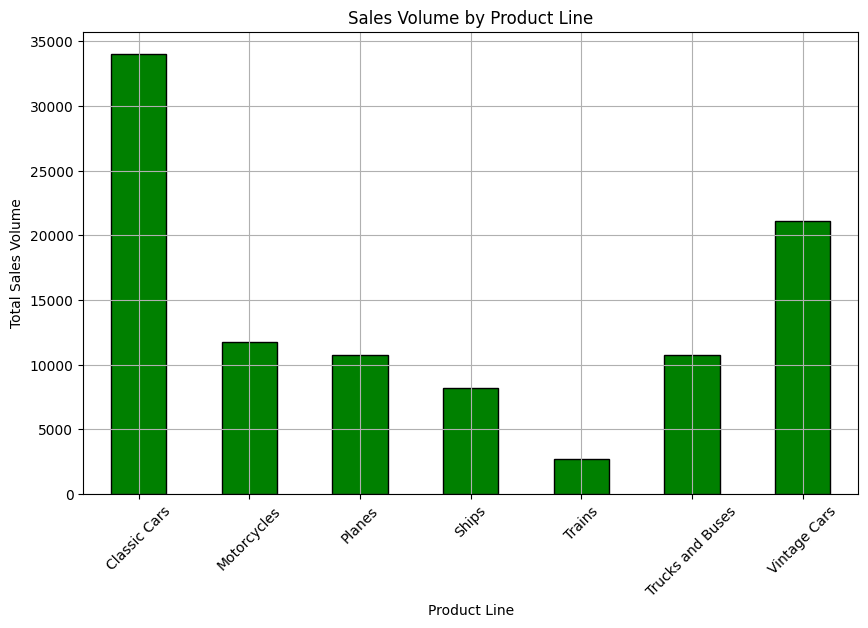

In [15]:
#3, Sales Volume by Product Line
sales_volume_by_product_line = consolidated_data.groupby('productline')['quantityordered'].sum()

plt.figure(figsize=(10, 6))
sales_volume_by_product_line.plot(kind='bar', color='green', edgecolor='black')
plt.title('Sales Volume by Product Line')
plt.xlabel('Product Line')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


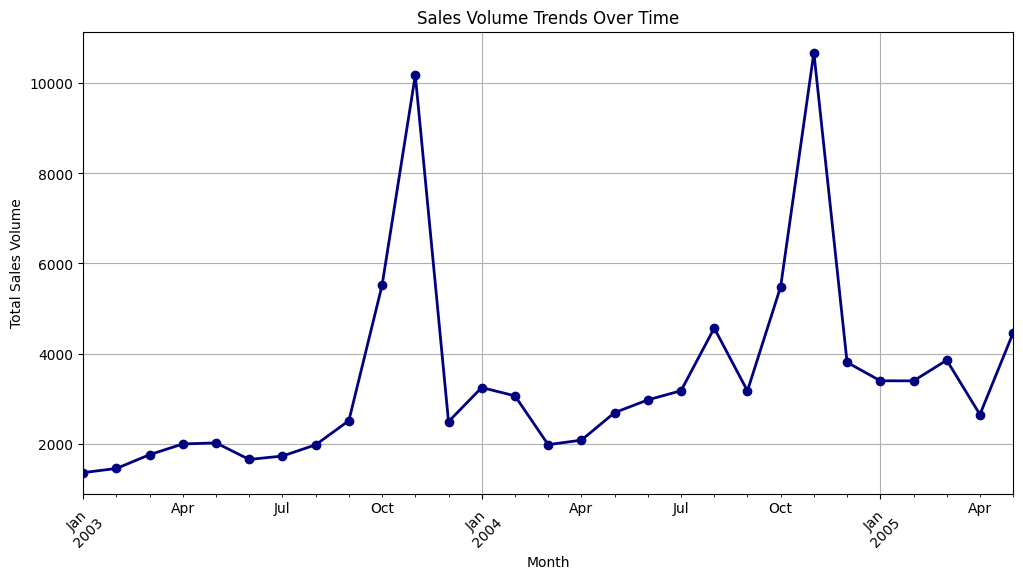

In [16]:
#4. Sales Trend Over time
consolidated_data['orderdate'] = pd.to_datetime(consolidated_data['orderdate'])

# Group by month and calculate the total sales volume (quantity ordered)
monthly_sales_volume = consolidated_data.groupby(consolidated_data['orderdate'].dt.to_period('M'))['quantityordered'].sum()

plt.figure(figsize=(12, 6))
monthly_sales_volume.plot(kind='line', color='navy', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('Sales Volume Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


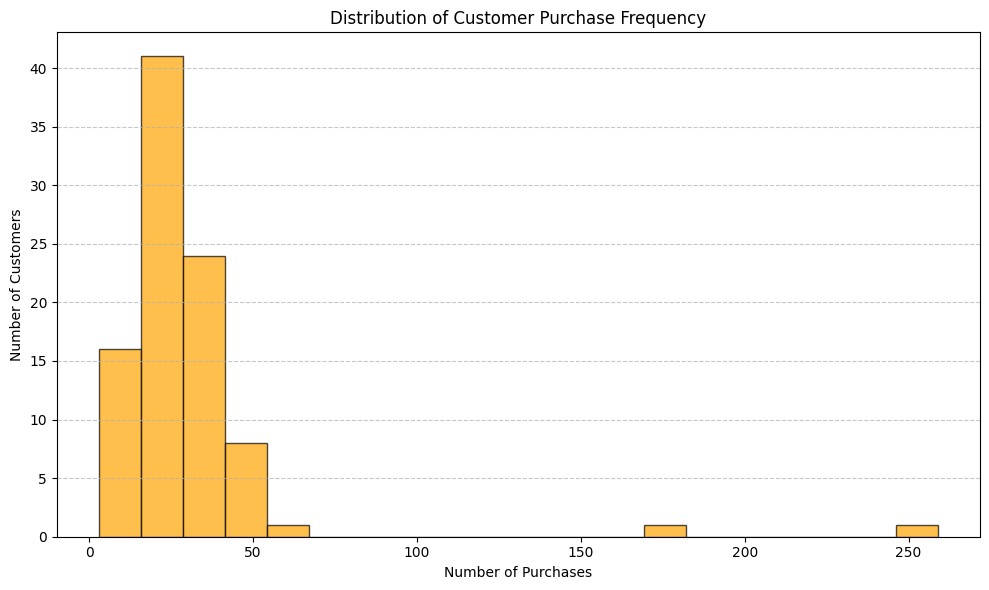

In [26]:
# Calculate customer purchase frequency using consolidated_data
customer_purchase_frequency = consolidated_data.groupby('customernumber')['ordernumber'].count()

# Visualize the distribution of customer purchase frequency
plt.figure(figsize=(10, 6))
plt.hist(customer_purchase_frequency, bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.title('Distribution of Customer Purchase Frequency')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to avoid clipping labels
plt.show()

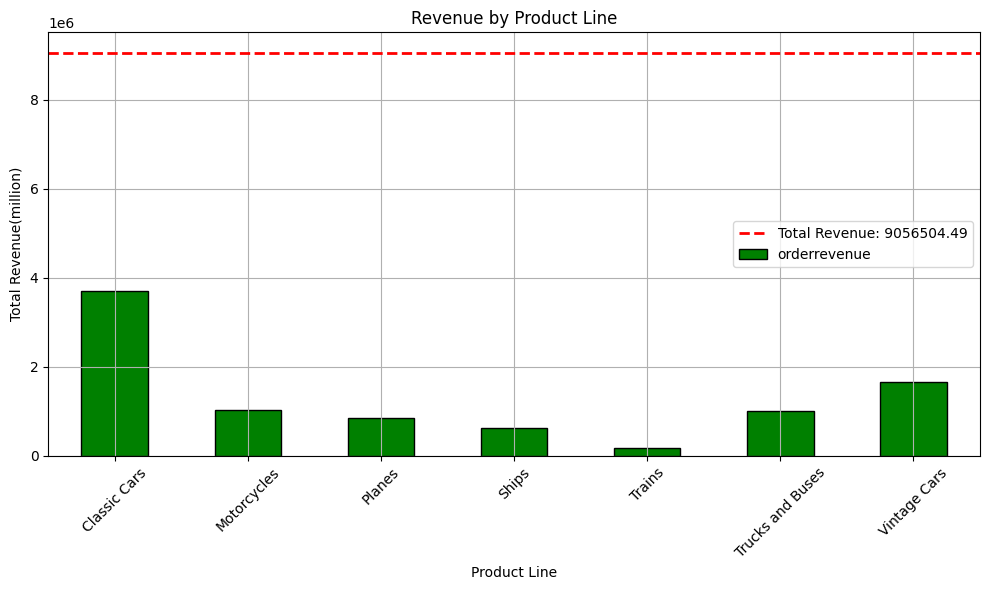

Total Revenue: 9056504.49


In [18]:
#Revenue by product line
revenue_by_product_line = consolidated_data.groupby('productline')['orderrevenue'].sum()
total_revenue = revenue_by_product_line.sum()

plt.figure(figsize=(10, 6))
revenue_by_product_line.plot(kind='bar', color='green', edgecolor='black')
plt.axhline(total_revenue, color='red', linestyle='dashed', linewidth=2, label=f'Total Revenue: {total_revenue:.2f}')
plt.title('Revenue by Product Line')
plt.xlabel('Product Line')
plt.ylabel('Total Revenue(million)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

print(f'Total Revenue: {total_revenue:.2f}')


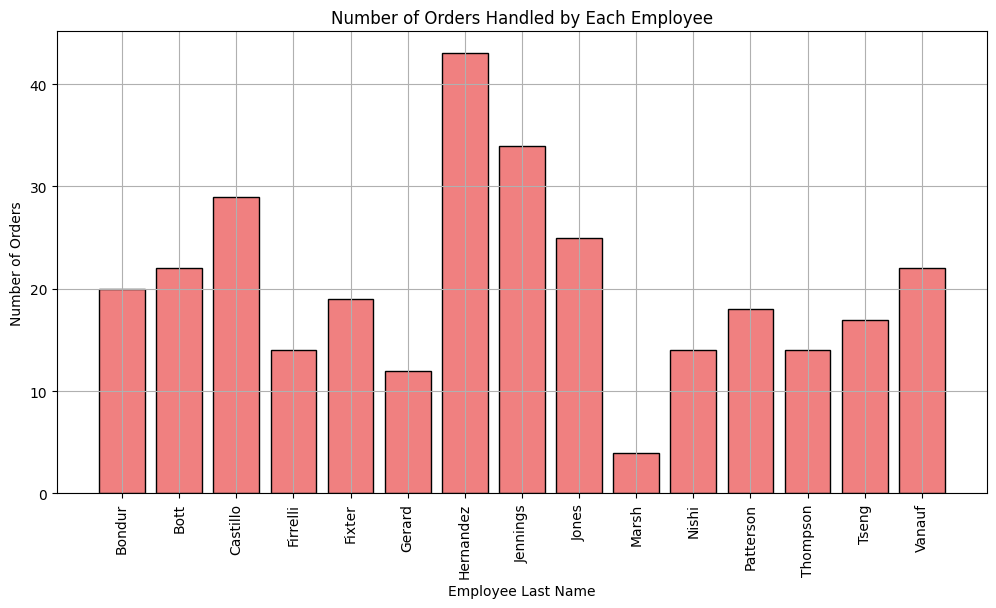

In [19]:
#Employee performance
employee_orders = pd.merge(consolidated_data, df_employees[['employeenumber', 'lastname', 'firstname']], 
                            left_on='salesrepemployeenumber', right_on='employeenumber')

employee_order_count = employee_orders.groupby('lastname')['ordernumber'].nunique().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(employee_order_count['lastname'], employee_order_count['ordernumber'], color='lightcoral', edgecolor='black')
plt.title('Number of Orders Handled by Each Employee')
plt.xlabel('Employee Last Name')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()



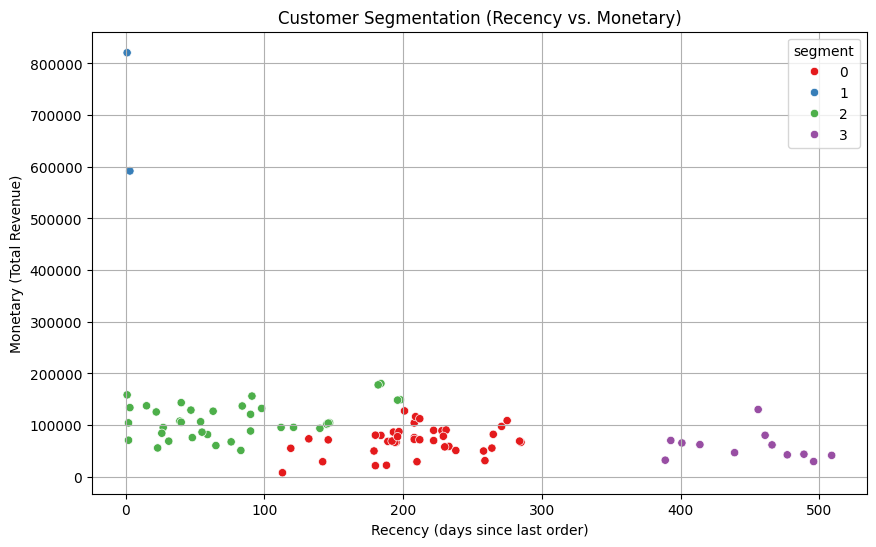

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19616\2402003775.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfm['segment'], y=rfm['ltv'], data=rfm,palette='viridis')


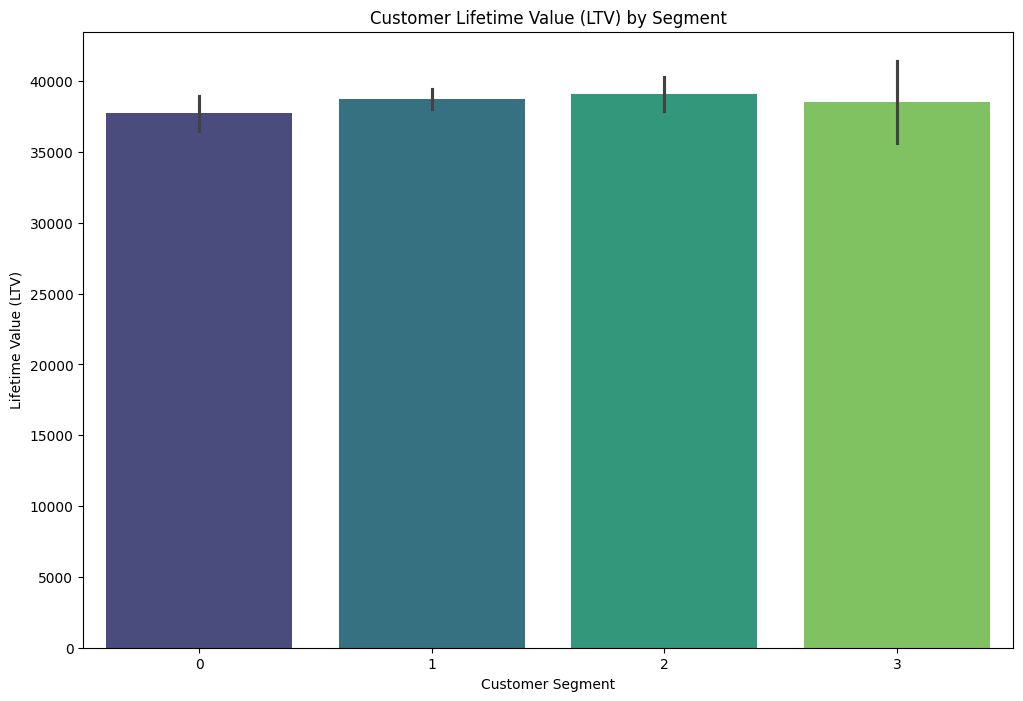

In [62]:

#------------------------------Part Two:Customer Segmentation and Lifetime Value---------------------------
#Calculate RFM values
consolidated_data['orderdate'] = pd.to_datetime(consolidated_data['orderdate'])
reference_date = consolidated_data['orderdate'].max() + pd.DateOffset(days=1)
consolidated_data['recency'] = (reference_date - consolidated_data['orderdate']).dt.days
frequency = consolidated_data.groupby('customernumber')['ordernumber'].count()
consolidated_data['orderrevenue'] = consolidated_data['quantityordered'] * consolidated_data['priceeach']
monetary = consolidated_data.groupby('customernumber')['orderrevenue'].sum()

rfm = pd.DataFrame({
    'recency': consolidated_data.groupby('customernumber')['recency'].min(),
    'frequency': frequency,
    'monetary': monetary
}).reset_index()

#Normalizimg the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

#Apply KMeans clustering to segment customers = 4 segments
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['segment'] = kmeans.fit_predict(rfm_scaled)

# Visualize the customer segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm['recency'], y=rfm['monetary'], hue=rfm['segment'], palette='Set1')
plt.title('Customer Segmentation (Recency vs. Monetary)')
plt.xlabel('Recency (days since last order)')
plt.ylabel('Monetary (Total Revenue)')
plt.grid(True)
plt.show()

# Step 5: Prediction of Lifetime Value (LTV)
rfm['ltv'] = rfm['monetary'] / rfm['frequency'] * 12

plt.figure(figsize=(12, 8))
sns.barplot(x=rfm['segment'], y=rfm['ltv'], data=rfm,palette='viridis')
plt.title('Customer Lifetime Value (LTV) by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Lifetime Value (LTV)')
plt.show()


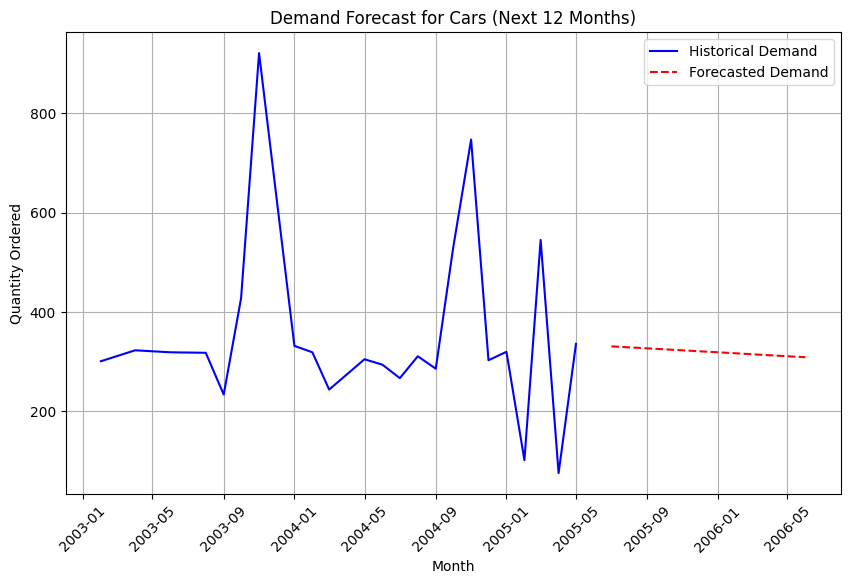

In [64]:
#-----------------------------Demand Prediction - Ships demand in the next year------------------------------------------
#Prepare Data: Aggregate monthly demand for a specific product line from consolidated_data
consolidated_data['orderdate'] = pd.to_datetime(consolidated_data['orderdate'])
consolidated_data['month'] = consolidated_data['orderdate'].dt.to_period('M')

#Total demand per product line per month
monthly_demand = consolidated_data.groupby(['month', 'productline'])['quantityordered'].sum().reset_index()

# Data for a specific product line (e.g., 'Ships')
product_demand = monthly_demand[monthly_demand['productline'] == 'Ships']

# Convert the 'month' period to a numerical feature for regression
product_demand['month_num'] = np.arange(len(product_demand))

# Prepare data for regression - Feature and Target
X = product_demand[['month_num']] 
y = product_demand['quantityordered']  

# Train a Linear Regression Model
model = LinearRegression()
model.fit(X, y)

# Forecast the next 12 months
future_months = np.arange(len(product_demand), len(product_demand) + 12).reshape(-1, 1)
forecast = model.predict(future_months)

# Visualize the demand forecast
plt.figure(figsize=(10, 6))
plt.plot(product_demand['month'].dt.to_timestamp(), product_demand['quantityordered'], label='Historical Demand', color='blue')
future_months_dates = pd.date_range(product_demand['month'].iloc[-1].end_time + pd.Timedelta(days=1), periods=12, freq='M')
plt.plot(future_months_dates, forecast, label='Forecasted Demand', color='red', linestyle='--')
plt.title('Demand Forecast for Cars (Next 12 Months)')
plt.xlabel('Month')
plt.ylabel('Quantity Ordered')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


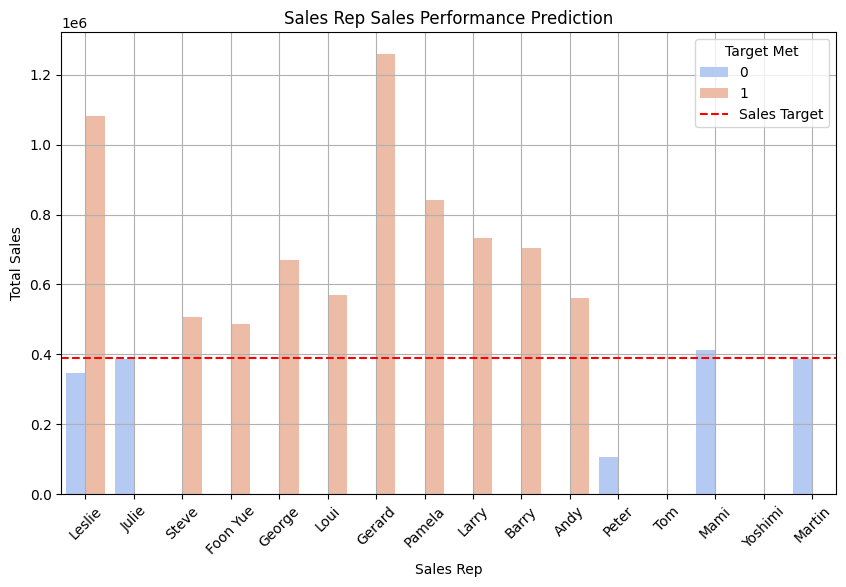

In [95]:
#-----------------------Sales Rep Performance----------------------------------
# Filter for Sales Representatives only
sales_reps = df_employees[df_employees['jobtitle'] == 'Sales Rep']

# Consolidate Sales Data
employee_sales = consolidated_data.groupby('salesrepemployeenumber')['orderrevenue'].sum().reset_index()
employee_sales.columns = ['employeenumber', 'total_sales']

# Merge with Employee Data
employee_performance = pd.merge(sales_reps, employee_sales, how='left', left_on='employeenumber', right_on='employeenumber')
employee_performance['total_sales'] = employee_performance['total_sales'].fillna(0)

# Set a Sales Target
sales_target = 390000
employee_performance['met_target'] = (employee_performance['total_sales'] >= sales_target).astype(int)

# Prepare Data for Prediction
# Use only total sales as a feature

# Select features and target
features = ['total_sales']
X = employee_performance[features]
y = employee_performance['met_target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


# Predict Target Achievement for All Employees
employee_performance['predicted_target'] = model.predict(X)

# Visualize Predictions
plt.figure(figsize=(10, 6))
sns.barplot(x='firstname', y='total_sales', hue='predicted_target', data=employee_performance, palette='coolwarm')
plt.axhline(sales_target, color='red', linestyle='--', label='Sales Target')
plt.title('Sales Rep Sales Performance Prediction')
plt.xlabel('Sales Rep')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Target Met')
plt.grid(True)
plt.show()
